Blank


In [1]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.metrics import Recall
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Dropout
from tensorflow.keras.callbacks import EarlyStopping
# oversampler func
from oversampler_funtion import over_sampler
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

import pickle
import tensorflow as tf

In [8]:
df = pd.read_csv('../../Data/complete_fire.csv')

In [9]:
df.dropna(inplace = True)

In [10]:
df.shape

(167273, 23)

In [11]:
df.dtypes

unique_fire_identifier     object
lattitude                 float64
longitude                 float64
acres_burned              float64
fire_cause                 object
incident_name              object
IsFSAssisted              float64
origin_county              object
state                      object
year                        int64
month                       int64
value                     float64
anomaly                   float64
area (acres)              float64
population                float64
d0                        float64
d1                        float64
d2                        float64
d3                        float64
d4                        float64
DSCI_avg                  float64
DSCI_summed               float64
precipitation(in)         float64
dtype: object

In [12]:
conditions = [df['acres_burned'] <= .25,
             (df['acres_burned'] > .25) & (df['acres_burned'] <= 9.9),
             (df['acres_burned'] > 9.9) & (df['acres_burned'] <= 99.99),
             (df['acres_burned'] > 99.99) & (df['acres_burned'] <= 299),
             (df['acres_burned'] > 299) & (df['acres_burned'] <= 999),
             (df['acres_burned'] > 999) & (df['acres_burned'] <= 5000),
             (df['acres_burned'] > 5000) & (df['acres_burned'] <= 9999),
             (df['acres_burned'] > 9999) & (df['acres_burned'] <= 49_999),
             (df['acres_burned'] > 49_999) & (df['acres_burned'] <= 100_000),
              (df['acres_burned'] > 100_000)
                
             ]
# choices = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J']
choices = [0,1,2,3,4,5,6,7,8,9]

df['class'] = np.select(conditions, choices, default = 'A')

In [13]:
df.dtypes

unique_fire_identifier     object
lattitude                 float64
longitude                 float64
acres_burned              float64
fire_cause                 object
incident_name              object
IsFSAssisted              float64
origin_county              object
state                      object
year                        int64
month                       int64
value                     float64
anomaly                   float64
area (acres)              float64
population                float64
d0                        float64
d1                        float64
d2                        float64
d3                        float64
d4                        float64
DSCI_avg                  float64
DSCI_summed               float64
precipitation(in)         float64
class                      object
dtype: object

In [14]:
df['class'].value_counts(normalize = True)

0    0.330621
1    0.230288
2    0.137398
5    0.112289
4    0.102718
3    0.080085
7    0.002983
6    0.002577
8    0.000544
9    0.000496
Name: class, dtype: float64

In [15]:

df = pd.get_dummies(df, columns = ['state', 'origin_county', 'fire_cause'], drop_first = True)

In [16]:
X = df.drop(columns = ['incident_name', 'unique_fire_identifier', 'class', 'acres_burned'])
y = df['class']

In [17]:
y = to_categorical(y)
# y = pd.get_dummies(y)

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 5, stratify = y)

In [19]:
sc = StandardScaler()

In [20]:
Z_train = sc.fit_transform(X_train)
Z_test = sc.transform(X_test)

In [21]:
X_train.shape

(125454, 1399)

In [22]:
model = Sequential()
model.add(Dense(32,
                input_shape = (1399,),
                activation = 'relu'))
model.add(Dense(10, activation = 'softmax'))

In [23]:
model.compile(loss = 'categorical_crossentropy',
              optimizer = 'adam',
              metrics = ['acc'])

In [24]:

history = model.fit(Z_train, y_train,
                    validation_data = (Z_test, y_test),
                    epochs = 10,
                    batch_size = 32,
                    verbose = 1)

Epoch 1/10
3921/3921 [==============================] - 33s 8ms/step - loss: 1.2466 - acc: 0.5450 - val_loss: 1.0747 - val_acc: 0.5945
Epoch 2/10
3921/3921 [==============================] - 27s 7ms/step - loss: 0.9876 - acc: 0.6181 - val_loss: 0.9660 - val_acc: 0.6290
Epoch 3/10
3921/3921 [==============================] - 33s 8ms/step - loss: 0.8933 - acc: 0.6454 - val_loss: 0.9131 - val_acc: 0.6524
Epoch 4/10
3921/3921 [==============================] - 32s 8ms/step - loss: 0.8328 - acc: 0.6657 - val_loss: 0.8778 - val_acc: 0.6642
Epoch 5/10
3921/3921 [==============================] - 33s 8ms/step - loss: 0.7957 - acc: 0.6795 - val_loss: 0.8637 - val_acc: 0.6737
Epoch 6/10
3921/3921 [==============================] - 32s 8ms/step - loss: 0.7657 - acc: 0.6900 - val_loss: 0.8605 - val_acc: 0.6814
Epoch 7/10
3921/3921 [==============================] - 31s 8ms/step - loss: 0.7426 - acc: 0.6978 - val_loss: 0.8604 - val_acc: 0.6859
Epoch 8/10
3921/3921 [==============================] -

In [23]:
preds = model.predict(Z_test)

In [24]:
rounded_preds = np.argmax(preds, axis = -1)
rounded_preds[101]

2

In [25]:
y_test2 = np.argmax(y_test, axis = -1)

In [26]:
y_test2[101]

2

In [28]:
from sklearn.metrics import classification_report
print(classification_report(y_test2, rounded_preds))

              precision    recall  f1-score   support

           0       0.61      0.83      0.70     13826
           1       0.47      0.35      0.40      9630
           2       0.63      0.49      0.55      5746
           3       0.70      0.58      0.63      3349
           4       0.80      0.73      0.76      4295
           5       0.88      0.86      0.87      4696
           6       0.50      0.01      0.02       108
           7       0.25      0.02      0.04       125
           8       0.00      0.00      0.00        23
           9       0.00      0.00      0.00        21

    accuracy                           0.64     41819
   macro avg       0.48      0.39      0.40     41819
weighted avg       0.63      0.64      0.63     41819



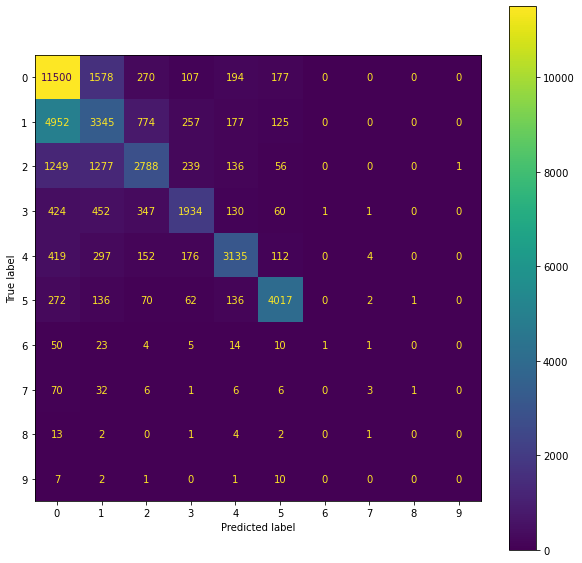

In [27]:

cm = confusion_matrix(y_test2, rounded_preds)

disp = ConfusionMatrixDisplay(confusion_matrix = cm,)
fig, ax = plt.subplots(figsize=(10,10))
disp.plot(ax=ax);


In [25]:
model2 = Sequential()
model2.add(Dense(64,
                input_shape = (1400,),
                activation = 'relu'))
model2.add(Dropout(0.2))
model2.add(Dense(64, activation = 'relu'))
model2.add(Dense(32, activation = 'relu'))

model2.add(Dense(10, activation = 'softmax'))

In [26]:
model2.compile(loss = 'categorical_crossentropy',
              optimizer = 'adam',
              metrics = ['acc'])

In [27]:
# early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=1, mode='auto')

history = model2.fit(Z_train, y_train,
                    validation_data = (Z_test, y_test),
                    epochs = 10,
                    batch_size = 32,
                    verbose = 1)

Epoch 1/10
3921/3921 [==============================] - 12s 3ms/step - loss: 1.1614 - acc: 0.5463 - val_loss: 0.9700 - val_acc: 0.6126
Epoch 2/10
3921/3921 [==============================] - 11s 3ms/step - loss: 0.9480 - acc: 0.6210 - val_loss: 0.8838 - val_acc: 0.6426
Epoch 3/10
3921/3921 [==============================] - 12s 3ms/step - loss: 0.8770 - acc: 0.6439 - val_loss: 0.8420 - val_acc: 0.6536
Epoch 4/10
3921/3921 [==============================] - 13s 3ms/step - loss: 0.8372 - acc: 0.6560 - val_loss: 0.7999 - val_acc: 0.6690
Epoch 5/10
3921/3921 [==============================] - 12s 3ms/step - loss: 0.8071 - acc: 0.6671 - val_loss: 0.7778 - val_acc: 0.6774
Epoch 6/10
 747/3921 [====>.........................] - ETA: 8s - loss: 0.7855 - acc: 0.6713

KeyboardInterrupt: 

In [ ]:
model3 = Sequential()
model3.add(Dense(128,
                input_shape = (1400,),
                activation = 'relu'))
model3.add(Dropout(0.2))
model3.add(Dense(64, activation = 'relu'))
model3.add(Dropout(0.2))
model3.add(Dense(32, activation = 'relu'))
model3.add(Dense(16, activation = 'relu'))

model3.add(Dense(10, activation = 'softmax'))

model3.compile(loss = 'categorical_crossentropy',
              optimizer = 'adam',
              metrics = ['acc'])

In [ ]:
history = model3.fit(Z_train, y_train,
                    validation_data = (Z_test, y_test),
                    epochs = 30,
                    batch_size = 64,
                    verbose = 1)

Epoch 1/30
1961/1961 [==============================] - 6s 3ms/step - loss: 1.2344 - acc: 0.5182 - val_loss: 1.0203 - val_acc: 0.6002
Epoch 2/30
1961/1961 [==============================] - 6s 3ms/step - loss: 1.0075 - acc: 0.6015 - val_loss: 0.9258 - val_acc: 0.6306
Epoch 3/30
1961/1961 [==============================] - 6s 3ms/step - loss: 0.9295 - acc: 0.6278 - val_loss: 0.8752 - val_acc: 0.6455
Epoch 4/30
1961/1961 [==============================] - 6s 3ms/step - loss: 0.8820 - acc: 0.6435 - val_loss: 0.8381 - val_acc: 0.6583
Epoch 5/30
1961/1961 [==============================] - 7s 3ms/step - loss: 0.8450 - acc: 0.6541 - val_loss: 0.8060 - val_acc: 0.6700
Epoch 6/30
1961/1961 [==============================] - 7s 3ms/step - loss: 0.8172 - acc: 0.6629 - val_loss: 0.7891 - val_acc: 0.6740
Epoch 7/30
1961/1961 [==============================] - 7s 4ms/step - loss: 0.7930 - acc: 0.6709 - val_loss: 0.7722 - val_acc: 0.6796
Epoch 8/30
1961/1961 [==============================] - 7s 4ms

In [ ]:
model4 = Sequential()
model4.add(Dense(128,
                input_shape = (1400,),
                activation = 'relu'))
model4.add(Dropout(0.2))
model4.add(Dense(64, activation = 'relu'))
model4.add(Dropout(0.2))
model4.add(Dense(32, activation = 'relu'))
model4.add(Dense(16, activation = 'relu'))
model4.add(Dense(16, activation = 'relu'))

model4.add(Dense(10, activation = 'softmax'))

model4.compile(loss = 'categorical_crossentropy',
              optimizer = 'adam',
              metrics = ['acc'])

In [ ]:
history = model4.fit(Z_train, y_train,
                    validation_data = (Z_test, y_test),
                    epochs = 100,
                    batch_size = 128,
                    verbose = 1)

Epoch 1/100
981/981 [==============================] - 5s 5ms/step - loss: 1.2801 - acc: 0.5069 - val_loss: 1.0558 - val_acc: 0.5879
Epoch 2/100
981/981 [==============================] - 4s 4ms/step - loss: 1.0334 - acc: 0.5933 - val_loss: 0.9459 - val_acc: 0.6245
Epoch 3/100
981/981 [==============================] - 4s 5ms/step - loss: 0.9522 - acc: 0.6222 - val_loss: 0.8976 - val_acc: 0.6418
Epoch 4/100
981/981 [==============================] - 4s 4ms/step - loss: 0.9011 - acc: 0.6370 - val_loss: 0.8588 - val_acc: 0.6545
Epoch 5/100
981/981 [==============================] - 5s 5ms/step - loss: 0.8654 - acc: 0.6486 - val_loss: 0.8326 - val_acc: 0.6620
Epoch 6/100
981/981 [==============================] - 4s 5ms/step - loss: 0.8372 - acc: 0.6562 - val_loss: 0.8067 - val_acc: 0.6687
Epoch 7/100
981/981 [==============================] - 4s 4ms/step - loss: 0.8148 - acc: 0.6651 - val_loss: 0.7963 - val_acc: 0.6737
Epoch 8/100
981/981 [==============================] - 4s 4ms/step - 

In [ ]:
preds4 = model4.predict(Z_test)

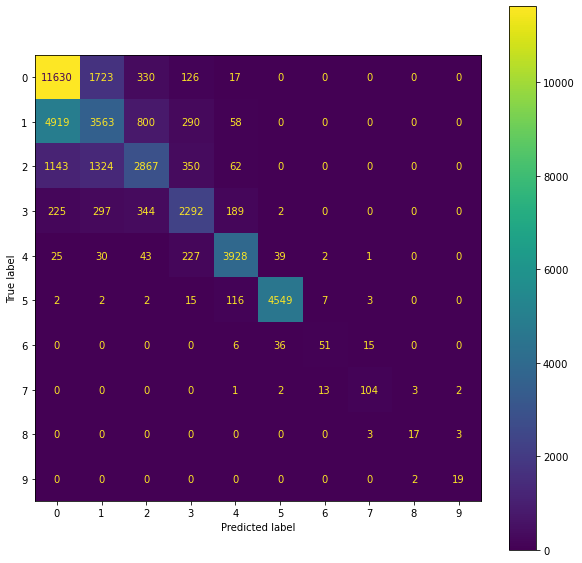

In [ ]:
rounded_preds4 = np.argmax(preds4, axis = -1)

y_test4 = np.argmax(y_test, axis = -1)

cm4 = confusion_matrix(y_test4, rounded_preds4)

disp4 = ConfusionMatrixDisplay(confusion_matrix = cm,)
fig, ax = plt.subplots(figsize=(10,10))
disp.plot(ax=ax)


---
Attempting best neural net with more balanced classes

In [41]:
df['class']  = df['class'].astype(int)
df['class'].dtypes

dtype('int64')

In [42]:
# matching the minority classes to the size of class 3
over_class3 = over_sampler(df,'class')
print(over_class3.shape[0])
over_class3['class'].value_counts()

What class do we want from needs to be an INT(our case ~ 0-9)? 3


219753


0    55304
1    38521
2    22983
5    18783
4    17182
3    13396
6    13396
7    13396
8    13396
9    13396
Name: class, dtype: int64

In [48]:
# looking at how much I need to strip from the oversampled df
diff = np.abs(df.shape[0]-over_class3.shape[0])
print('original',df.shape[0])
diff

original 167273


52480

In [50]:
# since this did not 
X = over_class3.drop(columns = ['incident_name', 'unique_fire_identifier', 'class'])
y = over_class3['class']
y = to_categorical(y)
# removing excessive data from the original df
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=diff,
                                                    random_state = 5, 
                                                    stratify = y)
print('Back to original dataframe: ',X_train.shape[0])

Back to original dataframe:  167273


In [52]:
# actually removing the 
X_train, X_test, y_train, y_test = train_test_split(X_train,
                                                    y_train, 
                                                    random_state = 5, 
                                                    stratify = y_train)

sc = StandardScaler()
Z_train = sc.fit_transform(X_train)
Z_test = sc.transform(X_test)

In [56]:
model4a = Sequential()
model4a.add(Dense(128,
                input_shape = (1400,),
                activation = 'relu'))
model4a.add(Dropout(0.2))
model4a.add(Dense(64, activation = 'relu'))
model4a.add(Dropout(0.2))
model4a.add(Dense(32, activation = 'relu'))
model4a.add(Dense(16, activation = 'relu'))
model4a.add(Dense(16, activation = 'relu'))

model4a.add(Dense(10, activation = 'softmax'))

model4a.compile(loss = 'categorical_crossentropy',
              optimizer = 'adam',
              metrics = ['acc'])
history = model4a.fit(Z_train, y_train,
                    validation_data = (Z_test, y_test),
                    epochs = 100,
                    batch_size = 128,

                      verbose = 1)

Epoch 1/100
981/981 [==============================] - 10s 9ms/step - loss: 1.4453 - acc: 0.4640 - val_loss: 1.0844 - val_acc: 0.5951
Epoch 2/100
981/981 [==============================] - 8s 8ms/step - loss: 1.0711 - acc: 0.5984 - val_loss: 0.9364 - val_acc: 0.6502
Epoch 3/100
981/981 [==============================] - 7s 8ms/step - loss: 0.9550 - acc: 0.6424 - val_loss: 0.8482 - val_acc: 0.6812
Epoch 4/100
981/981 [==============================] - 8s 9ms/step - loss: 0.8888 - acc: 0.6644 - val_loss: 0.8119 - val_acc: 0.6900
Epoch 5/100
981/981 [==============================] - 9s 9ms/step - loss: 0.8464 - acc: 0.6808 - val_loss: 0.7808 - val_acc: 0.7027
Epoch 6/100
981/981 [==============================] - 9s 9ms/step - loss: 0.8187 - acc: 0.6898 - val_loss: 0.7620 - val_acc: 0.7101
Epoch 7/100
981/981 [==============================] - 8s 9ms/step - loss: 0.7961 - acc: 0.6962 - val_loss: 0.7507 - val_acc: 0.7144
Epoch 8/100
981/981 [==============================] - 8s 9ms/step -

In [17]:
# use case example
over_class4 = over_sampler(df,'class')
print(over_class4.shape[0])
over_class4['class'].value_counts()

What class do we want from needs to be an INT(our case ~ 0-9)? 4


238683


0    55304
1    38521
2    22983
5    18783
3    17182
4    17182
6    17182
7    17182
8    17182
9    17182
Name: class, dtype: int64

In [57]:
# looking at how much I need to strip from the oversampled df
diff = np.abs(df.shape[0]-over_class4.shape[0])
print('original',df.shape[0])
print('difference: ',diff)
# since this did not 
X = over_class4.drop(columns = ['incident_name', 'unique_fire_identifier', 'class'])
y = over_class4['class']
y = to_categorical(y)
# removing excessive data from the original df
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=diff,
                                                    random_state = 5, 
                                                    stratify = y)
print('Back to original dataframe: ',X_train.shape[0])

# actually removing the 
X_train, X_test, y_train, y_test = train_test_split(X_train,
                                                    y_train, 
                                                    random_state = 5, 
                                                    stratify = y_train)

sc = StandardScaler()
Z_train = sc.fit_transform(X_train)
Z_test = sc.transform(X_test)

model4b = Sequential()
model4b.add(Dense(128,
                input_shape = (1400,),
                activation = 'relu'))
model4b.add(Dropout(0.2))
model4b.add(Dense(64, activation = 'relu'))
model4b.add(Dropout(0.2))
model4b.add(Dense(32, activation = 'relu'))
model4b.add(Dense(16, activation = 'relu'))
model4b.add(Dense(16, activation = 'relu'))

model4b.add(Dense(10, activation = 'softmax'))

model4b.compile(loss = 'categorical_crossentropy',
              optimizer = 'adam',
              metrics = ['acc'])
history = model4b.fit(Z_train, y_train,
                    validation_data = (Z_test, y_test),
                    epochs = 100,
                    batch_size = 128,

                      verbose = 1)

original 167273
difference:  71410
Back to original dataframe:  167273
Epoch 1/100
981/981 [==============================] - 11s 11ms/step - loss: 1.4165 - acc: 0.4716 - val_loss: 1.0648 - val_acc: 0.5985
Epoch 2/100
981/981 [==============================] - 9s 9ms/step - loss: 1.0397 - acc: 0.6123 - val_loss: 0.9219 - val_acc: 0.6548
Epoch 3/100
981/981 [==============================] - 8s 8ms/step - loss: 0.9232 - acc: 0.6552 - val_loss: 0.8239 - val_acc: 0.6921
Epoch 4/100
981/981 [==============================] - 9s 9ms/step - loss: 0.8617 - acc: 0.6768 - val_loss: 0.7850 - val_acc: 0.7058
Epoch 5/100
981/981 [==============================] - 9s 9ms/step - loss: 0.8203 - acc: 0.6918 - val_loss: 0.7597 - val_acc: 0.7124
Epoch 6/100
981/981 [==============================] - 8s 8ms/step - loss: 0.7920 - acc: 0.7004 - val_loss: 0.7455 - val_acc: 0.7196
Epoch 7/100
981/981 [==============================] - 8s 8ms/step - loss: 0.7717 - acc: 0.7071 - val_loss: 0.7484 - val_acc: 0.7

---
Best Overall Performing

In [16]:
# use case example
over_class5 = over_sampler(df,'class')
print(over_class5.shape[0])
over_class5['class'].value_counts()

What class do we want from needs to be an INT(our case ~ 0-9)? 5


248289


0    55304
1    38521
2    22983
3    18783
4    18783
5    18783
6    18783
7    18783
8    18783
9    18783
Name: class, dtype: int64

In [59]:
# looking at how much I need to strip from the oversampled df
diff = np.abs(df.shape[0]-over_class5.shape[0])
print('original',df.shape[0])
print('difference: ',diff)
# since this did not 
X = over_class5.drop(columns = ['incident_name', 'unique_fire_identifier', 'class'])
y = over_class5['class']
y = to_categorical(y)
# removing excessive data from the original df
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=diff,
                                                    random_state = 5, 
                                                    stratify = y)
print('Back to original dataframe: ',X_train.shape[0])

# actually removing the 
X_train, X_test, y_train, y_test = train_test_split(X_train,
                                                    y_train, 
                                                    random_state = 5, 
                                                    stratify = y_train)

sc = StandardScaler()
Z_train = sc.fit_transform(X_train)
Z_test = sc.transform(X_test)

model4c = Sequential()
model4c.add(Dense(128,
                input_shape = (1400,),
                activation = 'relu'))
model4c.add(Dropout(0.2))
model4c.add(Dense(64, activation = 'relu'))
model4c.add(Dropout(0.2))
model4c.add(Dense(32, activation = 'relu'))
model4c.add(Dense(16, activation = 'relu'))
model4c.add(Dense(16, activation = 'relu'))

model4c.add(Dense(10, activation = 'softmax'))

model4c.compile(loss = 'categorical_crossentropy',
              optimizer = 'adam',
              metrics = ['acc'])
history = model4c.fit(Z_train, y_train,
                    validation_data = (Z_test, y_test),
                    epochs = 100,
                    batch_size = 128,

                      verbose = 1)

original 167273
difference:  81016
Back to original dataframe:  167273
Epoch 1/100
981/981 [==============================] - 10s 10ms/step - loss: 1.3943 - acc: 0.4840 - val_loss: 1.0469 - val_acc: 0.6113
Epoch 2/100
981/981 [==============================] - 8s 8ms/step - loss: 1.0362 - acc: 0.6152 - val_loss: 0.9089 - val_acc: 0.6676
Epoch 3/100
981/981 [==============================] - 8s 8ms/step - loss: 0.9252 - acc: 0.6573 - val_loss: 0.8301 - val_acc: 0.6959
Epoch 4/100
981/981 [==============================] - 8s 9ms/step - loss: 0.8612 - acc: 0.6805 - val_loss: 0.8111 - val_acc: 0.6974
Epoch 5/100
981/981 [==============================] - 8s 8ms/step - loss: 0.8190 - acc: 0.6957 - val_loss: 0.7672 - val_acc: 0.7160
Epoch 6/100
981/981 [==============================] - 7s 8ms/step - loss: 0.7922 - acc: 0.7040 - val_loss: 0.7499 - val_acc: 0.7262
Epoch 7/100
981/981 [==============================] - 8s 8ms/step - loss: 0.7692 - acc: 0.7117 - val_loss: 0.7387 - val_acc: 0.7

In [65]:
y_true = y_test
y_pred = model4c.predict(X_test)
preds = model4c.predict(Z_test)

rounded_preds4c = np.argmax(preds, axis = -1)
y_test4c = np.argmax(y_test, axis = -1)

print(classification_report(y_test4c, rounded_preds4c))


              precision    recall  f1-score   support

           0       0.65      0.20      0.30     13770
           1       0.55      0.23      0.32      9591
           2       0.82      0.21      0.33      5723
           3       0.44      0.31      0.37      3335
           4       0.30      0.06      0.09      4278
           5       0.15      0.07      0.09      4677
           6       0.00      0.05      0.00       107
           7       0.00      0.06      0.00       124
           8       0.01      0.04      0.02       107
           9       0.37      1.00      0.54       107

    accuracy                           0.19     41819
   macro avg       0.33      0.22      0.21     41819
weighted avg       0.53      0.19      0.27     41819



---

In [19]:
# use case example
over_class6 = over_sampler(df,'class')
print(over_class6.shape[0])
over_class6['class'].value_counts()

What class do we want from needs to be an INT(our case ~ 0-9)? 6


167961


0    55304
1    38521
2    22983
5    18783
4    17182
3    13396
7      499
6      431
8      431
9      431
Name: class, dtype: int64

In [60]:
# looking at how much I need to strip from the oversampled df
diff = np.abs(df.shape[0]-over_class6.shape[0])
print('original',df.shape[0])
print('difference: ',diff)
# since this did not 
X = over_class6.drop(columns = ['incident_name', 'unique_fire_identifier', 'class'])
y = over_class6['class']
y = to_categorical(y)
# removing excessive data from the original df
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=diff,
                                                    random_state = 5, 
                                                    stratify = y)
print('Back to original dataframe: ',X_train.shape[0])

# actually removing the 
X_train, X_test, y_train, y_test = train_test_split(X_train,
                                                    y_train, 
                                                    random_state = 5, 
                                                    stratify = y_train)

sc = StandardScaler()
Z_train = sc.fit_transform(X_train)
Z_test = sc.transform(X_test)

model4d = Sequential()
model4d.add(Dense(128,
                input_shape = (1400,),
                activation = 'relu'))
model4d.add(Dropout(0.2))
model4d.add(Dense(64, activation = 'relu'))
model4d.add(Dropout(0.2))
model4d.add(Dense(32, activation = 'relu'))
model4d.add(Dense(16, activation = 'relu'))
model4d.add(Dense(16, activation = 'relu'))

model4d.add(Dense(10, activation = 'softmax'))

model4d.compile(loss = 'categorical_crossentropy',
              optimizer = 'adam',
              metrics = ['acc'])
history = model4d.fit(Z_train, y_train,
                    validation_data = (Z_test, y_test),
                    epochs = 100,
                    batch_size = 128,

                      verbose = 1)

original 167273
difference:  688
Back to original dataframe:  167273
Epoch 1/100
981/981 [==============================] - 9s 8ms/step - loss: 1.3237 - acc: 0.4977 - val_loss: 1.0857 - val_acc: 0.5840
Epoch 2/100
981/981 [==============================] - 8s 8ms/step - loss: 1.0734 - acc: 0.5900 - val_loss: 0.9939 - val_acc: 0.6156
Epoch 3/100
981/981 [==============================] - 8s 8ms/step - loss: 1.0090 - acc: 0.6114 - val_loss: 0.9537 - val_acc: 0.6299
Epoch 4/100
981/981 [==============================] - 7s 7ms/step - loss: 0.9672 - acc: 0.6261 - val_loss: 0.9267 - val_acc: 0.6399
Epoch 5/100
981/981 [==============================] - 8s 8ms/step - loss: 0.9370 - acc: 0.6345 - val_loss: 0.9060 - val_acc: 0.6437
Epoch 6/100
981/981 [==============================] - 10s 11ms/step - loss: 0.9131 - acc: 0.6414 - val_loss: 0.8830 - val_acc: 0.6506
Epoch 7/100
981/981 [==============================] - 8s 8ms/step - loss: 0.8934 - acc: 0.6477 - val_loss: 0.8748 - val_acc: 0.654

---
Exporting Neural Net ([source](https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/distribute/save_and_load.ipynb#scrollTo=WrXAAVtrzRgv))  
This is for proof of concept for streamlit app purposes ONLY feel free to skip code below.

In [25]:
# exporting demo for streamlit
keras_model_path = './keras_save'
model.save(keras_model_path)

INFO:tensorflow:Assets written to: ./keras_save/assets


In [31]:
restored_keras_model = tf.keras.models.load_model(keras_model_path)
restored_preds = restored_keras_model.predict(Z_test)

In [41]:
# 0riginal model above
y_true = y_test
preds = model.predict(Z_test)
rounded_preds = np.argmax(preds, axis = -1)
y_test_demo = np.argmax(y_test, axis = -1)
print(classification_report(y_test_demo, rounded_preds))

              precision    recall  f1-score   support

           0       0.67      0.78      0.72     13826
           1       0.49      0.47      0.48      9630
           2       0.65      0.51      0.57      5746
           3       0.76      0.65      0.70      3349
           4       0.93      0.92      0.92      4295
           5       0.97      0.98      0.98      4696
           6       0.64      0.45      0.53       108
           7       0.84      0.87      0.85       125
           8       1.00      0.35      0.52        23
           9       0.78      1.00      0.88        21

    accuracy                           0.70     41819
   macro avg       0.77      0.70      0.71     41819
weighted avg       0.69      0.70      0.69     41819



In [40]:
y_true = y_test
y_pred = restored_keras_model.predict(X_test)
preds = restored_keras_model.predict(Z_test)
rounded_preds_pickle = np.argmax(preds, axis = -1)
y_test_demo = np.argmax(y_test, axis = -1)
print(classification_report(y_test_demo, rounded_preds_pickle))

              precision    recall  f1-score   support

           0       0.67      0.78      0.72     13826
           1       0.49      0.47      0.48      9630
           2       0.65      0.51      0.57      5746
           3       0.76      0.65      0.70      3349
           4       0.93      0.92      0.92      4295
           5       0.97      0.98      0.98      4696
           6       0.64      0.45      0.53       108
           7       0.84      0.87      0.85       125
           8       1.00      0.35      0.52        23
           9       0.78      1.00      0.88        21

    accuracy                           0.70     41819
   macro avg       0.77      0.70      0.71     41819
weighted avg       0.69      0.70      0.69     41819



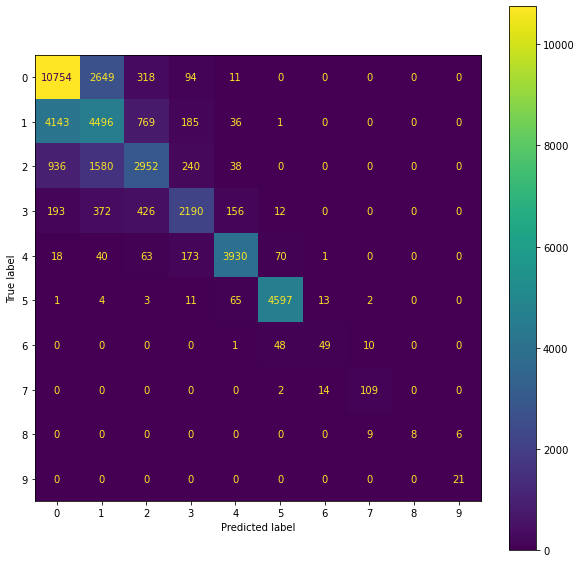

In [37]:
rounded_preds = np.argmax(restored_preds, axis = -1)
y_test2 = np.argmax(y_test, axis = -1)
cm = confusion_matrix(y_test2, rounded_preds)
disp = ConfusionMatrixDisplay(confusion_matrix = cm,)
fig, ax = plt.subplots(figsize=(10,10))
disp.plot(ax=ax);

# Using dataset with imputed averages by region (imputed_complete_fire)

In [15]:
df_imputed = pd.read_csv('../../Data/imputed_complete_fire.csv')
df_imputed.drop(columns = 'Unnamed: 0',inplace=True)
df_imputed.head()

,unique_fire_identifier,lattitude,longitude,acres_burned,fire_cause,incident_name,IsFSAssisted,origin_county,state,year,...,population,d0,d1,d2,d3,d4,DSCI_avg,DSCI_summed,precipitation(in),regions
0,2003-WYCMX-200237,-105.563067,44.603340,139.091837,Unknown,SCHWARTZ,1.0,Campbell,WY,2003,...,3.303917e+06,18.249151,14.653462,12.028498,11.200130,5.348644,184.442738,802.985483,0.049736,Mountain
1,2004-CABDU-006784,-117.076679,34.733894,1906.698008,Unknown,MENTONE,1.0,San Bernardino,CA,2004,...,3.680509e+07,12.676957,14.073960,14.320113,15.726569,9.183301,225.324333,972.517550,0.020251,Pacific
2,2008-IDGBK-000002,-116.216680,43.666673,685.728842,Unknown,NIFC RAMP SUPPORT,1.0,Ada,ID,2008,...,3.303917e+06,18.249151,14.653462,12.028498,11.200130,5.348644,184.442738,802.985483,0.049736,Mountain
3,2008-IDCTF-008902,-111.426912,42.096336,20.000000,Unknown,St. Charles RX,0.0,Bear Lake,ID,2008,...,3.303917e+06,18.249151,14.653462,12.028498,11.200130,5.348644,184.442738,802.985483,0.049736,Mountain
4,2008-AZPNF-000975,-112.072414,34.598306,77.946287,Unknown,Mingus/Cherry Rx,0.0,Yavapai,AZ,2008,...,3.303917e+06,18.249151,14.653462,12.028498,11.200130,5.348644,184.442738,802.985483,0.049736,Mountain


In [16]:
conditions = [df_imputed['acres_burned'] <= .25,
             (df_imputed['acres_burned'] > .25) & (df_imputed['acres_burned'] <= 9.9),
             (df_imputed['acres_burned'] > 9.9) & (df_imputed['acres_burned'] <= 99.99),
             (df_imputed['acres_burned'] > 99.99) & (df_imputed['acres_burned'] <= 299),
             (df_imputed['acres_burned'] > 299) & (df_imputed['acres_burned'] <= 999),
             (df_imputed['acres_burned'] > 999) & (df_imputed['acres_burned'] <= 5000),
             (df_imputed['acres_burned'] > 5000) & (df_imputed['acres_burned'] <= 9999),
             (df_imputed['acres_burned'] > 9999) & (df_imputed['acres_burned'] <= 49_999),
             (df_imputed['acres_burned'] > 49_999) & (df_imputed['acres_burned'] <= 100_000),
              (df_imputed['acres_burned'] > 100_000)
                
             ]
# choices = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J']
choices = [0,1,2,3,4,5,6,7,8,9]

df_imputed['class'] = np.select(conditions, choices, default = 'A')

In [17]:
df_imputed.columns

Index(['unique_fire_identifier', 'lattitude', 'longitude', 'acres_burned',
       'fire_cause', 'incident_name', 'IsFSAssisted', 'origin_county', 'state',
       'year', 'month', 'value', 'anomaly', 'area (acres)', 'population', 'd0',
       'd1', 'd2', 'd3', 'd4', 'DSCI_avg', 'DSCI_summed', 'precipitation(in)',
       'regions', 'class'],
      dtype='object')

In [18]:
df_imputed = pd.get_dummies(df_imputed, columns = ['state','regions', 'origin_county', 'fire_cause'], drop_first = True)

In [22]:
X = df_imputed.drop(columns = ['incident_name','acres_burned' ,'unique_fire_identifier', 'class'])
y = df_imputed['class']
y = to_categorical(y)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 5, stratify = y)

sc = StandardScaler()
Z_train = sc.fit_transform(X_train)
Z_test = sc.transform(X_test)

In [24]:
Z_train.shape

(160340, 1520)

In [25]:
model = Sequential()
model.add(Dense(32,
                input_shape = (1520,),
                activation = 'relu'))
model.add(Dense(10, activation = 'softmax'))
model.compile(loss = 'categorical_crossentropy',
              optimizer = 'adam',
              metrics = ['acc'])

history = model.fit(Z_train, y_train,
                    validation_data = (Z_test, y_test),
                    epochs = 10,
                    batch_size = 32,
                    verbose = 1)

Epoch 1/10
5011/5011 [==============================] - 47s 9ms/step - loss: 1.3309 - acc: 0.5129 - val_loss: 1.2186 - val_acc: 0.5479
Epoch 2/10
5011/5011 [==============================] - 16s 3ms/step - loss: 1.1787 - acc: 0.5668 - val_loss: 1.1819 - val_acc: 0.5732
Epoch 3/10
5011/5011 [==============================] - 21s 4ms/step - loss: 1.1261 - acc: 0.5899 - val_loss: 1.1760 - val_acc: 0.5919
Epoch 4/10
5011/5011 [==============================] - 19s 4ms/step - loss: 1.0983 - acc: 0.6017 - val_loss: 1.1766 - val_acc: 0.5975
Epoch 5/10
5011/5011 [==============================] - 20s 4ms/step - loss: 1.0772 - acc: 0.6093 - val_loss: 1.1768 - val_acc: 0.6022
Epoch 6/10
5011/5011 [==============================] - 18s 4ms/step - loss: 1.0639 - acc: 0.6157 - val_loss: 1.1863 - val_acc: 0.6026
Epoch 7/10
5011/5011 [==============================] - 20s 4ms/step - loss: 1.0538 - acc: 0.6186 - val_loss: 1.2190 - val_acc: 0.6087
Epoch 8/10
5011/5011 [==============================] -

In [26]:
# 0riginal model above
y_true = y_test
preds = model.predict(Z_test)
rounded_preds = np.argmax(preds, axis = -1)
y_test_demo = np.argmax(y_test, axis = -1)
print(classification_report(y_test_demo, rounded_preds))
# BEFORE ACRES BURNED  DROPPED macro avg       0.77      0.70      0.71  

              precision    recall  f1-score   support

           0       0.60      0.82      0.69     17141
           1       0.46      0.37      0.41     12241
           2       0.61      0.50      0.55      7864
           3       0.65      0.48      0.55      4653
           4       0.75      0.65      0.69      5584
           5       0.82      0.81      0.81      5527
           6       0.00      0.00      0.00       167
           7       0.00      0.00      0.00       201
           8       0.00      0.00      0.00        39
           9       0.00      0.00      0.00        30

    accuracy                           0.61     53447
   macro avg       0.39      0.36      0.37     53447
weighted avg       0.61      0.61      0.60     53447



/opt/anaconda3/envs/tf_keras/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/envs/tf_keras/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/envs/tf_keras/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


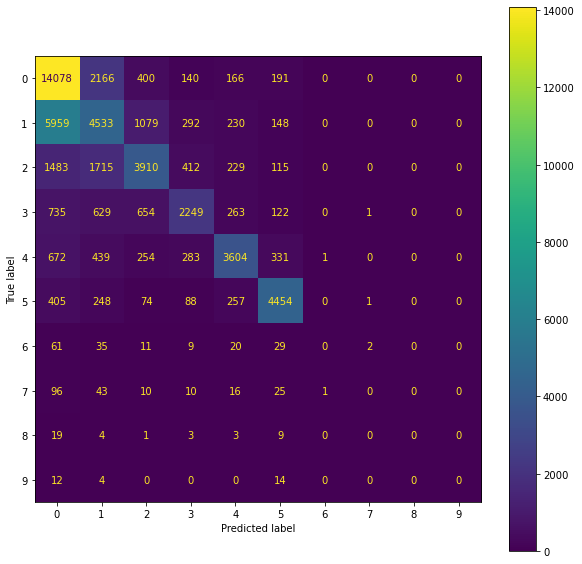

In [27]:
cm = confusion_matrix(y_test_demo, rounded_preds)
disp = ConfusionMatrixDisplay(confusion_matrix = cm,)
fig, ax = plt.subplots(figsize=(10,10))
disp.plot(ax=ax);